In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()
# index = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})
# index

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [7]:
rolling_window = 10
market.connect()
prices = []
skips = 1
for ticker in tqdm(index["ticker"][::skips]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            dividends = market.query("dividends",{"ticker":ticker})
            if dividends.index.size > 0:
                dividends = p.utc_date(dividends)
                price = price.merge(dividends,on=["date","ticker"])
                price["dividend"] = price["rate"].ffill().fillna(0)
            else:
                price["dividend"] = 0
            price = Metric.DISTANCE.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_CLOSE.calculate(price,timeframe=rolling_window)
            price = Indicator.EMACorr.calculate(price,timeframe=rolling_window)
            price = RiskType.COEFFICIENT_OF_VARIATION.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 19%|█████████████████████████████▏                                                                                                                         | 2173/11261 [00:45<03:22, 44.84it/s]

index 0 is out of bounds for axis 0 with size 0


 30%|█████████████████████████████████████████████▌                                                                                                         | 3396/11261 [01:13<03:06, 42.11it/s]

index 0 is out of bounds for axis 0 with size 0


 45%|███████████████████████████████████████████████████████████████████▌                                                                                   | 5042/11261 [01:51<02:59, 34.72it/s]

index 0 is out of bounds for axis 0 with size 0


 46%|█████████████████████████████████████████████████████████████████████▊                                                                                 | 5211/11261 [01:54<02:14, 44.83it/s]

index 0 is out of bounds for axis 0 with size 0


 48%|████████████████████████████████████████████████████████████████████████▌                                                                              | 5414/11261 [01:59<01:56, 50.33it/s]

index 0 is out of bounds for axis 0 with size 0


 48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 5440/11261 [01:59<02:20, 41.37it/s]

index 0 is out of bounds for axis 0 with size 0


 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 5720/11261 [02:06<02:04, 44.53it/s]

index 0 is out of bounds for axis 0 with size 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8782/11261 [03:17<00:51, 48.07it/s]

index 0 is out of bounds for axis 0 with size 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9808/11261 [03:41<00:29, 49.41it/s]

index 0 is out of bounds for axis 0 with size 0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 10221/11261 [03:51<00:20, 51.95it/s]

index 0 is out of bounds for axis 0 with size 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11261/11261 [04:16<00:00, 43.97it/s]


In [8]:
model_end = 2020
backtest_end = 2026
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [9]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                                            ranking_metrics=[
                                                                "ema_corr"
                                                            ]
                                                            ,num_of_groups=[3]
                                                            ,group_percentages=[1]
                                                            ,max_prices=[3]
                                                            ,min_prices=[1]
                                                            ,stoplosses=[0.05]
                                                            ,rolling_windows=[rolling_window]
                                                            )
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "day"  and "top_blacklist" in portfolio.selection_type.label  and portfolio.allocation_type.label == "risk" \
            and portfolio.position_type.label == "long" and "distance" in portfolio.grouping_type.value   and portfolio.max_price > portfolio.min_price:
            filtered_portfolios.append(portfolio)
len(filtered_portfolios)

1

In [10]:
analysises = []
portfolio_value = 10
for portfolio in tqdm(filtered_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.31s/it]


In [11]:
a = pd.DataFrame(analysises)

In [12]:
metric = "raw_pnl"
dropped_columns = ["date","risk_type","timeframe","selection_percentage","stoploss","position_type","rolling_window","portfolio"]
filtered_a = a.drop(dropped_columns,axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,grouping_type,selection_type,allocation_type,num_of_groups,max_price,min_price,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,sharpe_ratio,tracking_error,information_ratio
0,ema_corr,DISTANCE,top_blacklist,risk,3,3,1,117319.363001,3.686494e+06,0.95,5.102594,22992.100884,5.102499,22991.763381,5.102574


In [13]:
# orivault.cloud_connect()
# orivault.drop("results")
# orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
# orivault.disconnect()

In [14]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

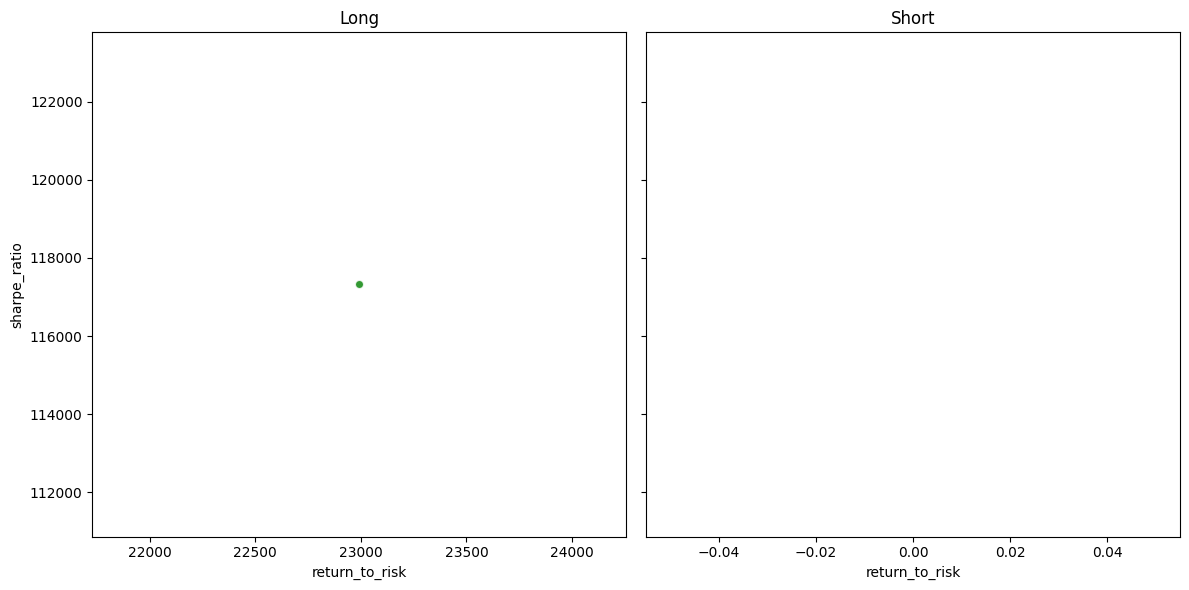

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [16]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

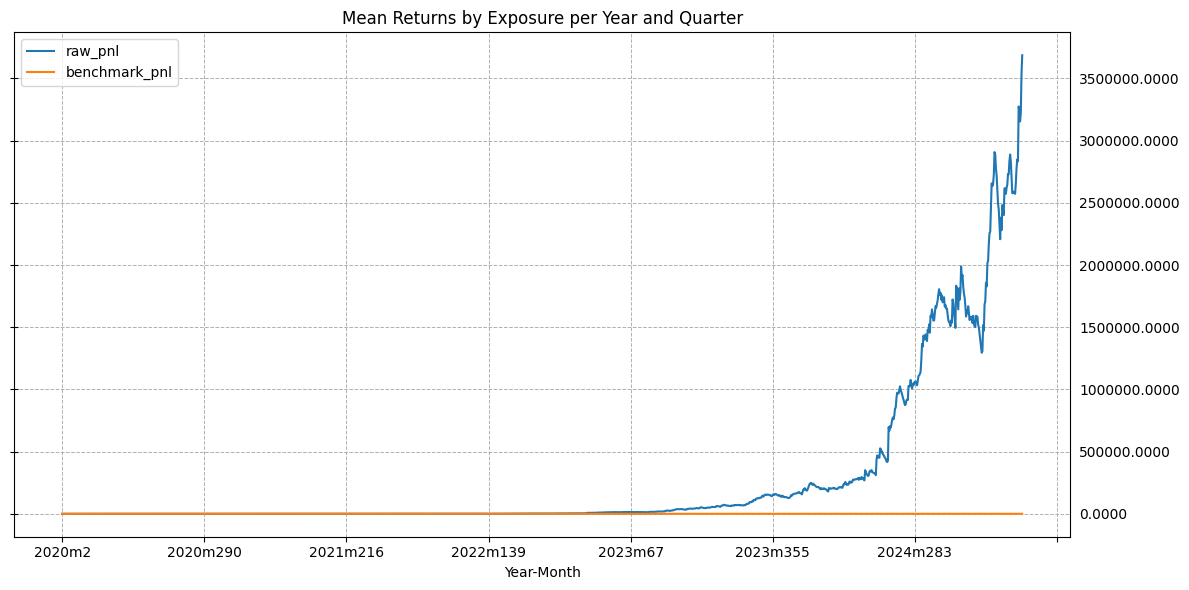

In [17]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio[pm.timeframe.value].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
PLAG,0.163541
UONE,0.137672
INDO,0.120776
AEHL,0.105074
PHVS,0.088136
...,...
SCWO,-0.028508
IMCC,-0.030650
GVH,-0.030706


In [19]:
portfolio.sort_values("date")

,index,year,day,date,weighted_return,return,pnl,raw_pnl,benchmark,benchmark_pnl,month,quarter,week,Year-Month
0,0,2020,2,2020-01-02 00:00:00+00:00,0.964495,0.964495,0.964495,9.644953e-01,120.64,1.000000,1,1,1,2020m2
1,1,2020,3,2020-01-03 00:00:00+00:00,1.029743,1.029743,0.993182,9.931824e-01,119.06,0.986903,1,1,1,2020m3
2,2,2020,6,2020-01-06 00:00:00+00:00,1.050897,1.050897,1.043733,1.043733e+00,118.97,0.986157,1,1,2,2020m6
3,3,2020,7,2020-01-07 00:00:00+00:00,0.997953,0.997953,1.041596,1.041596e+00,116.94,0.969330,1,1,2,2020m7
4,4,2020,8,2020-01-08 00:00:00+00:00,0.969712,0.969712,1.010049,1.010049e+00,117.86,0.976956,1,1,2,2020m8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,1347,2025,133,2025-05-13 00:00:00+00:00,0.986537,0.986537,102810.463119,3.230585e+06,263.01,2.180123,5,2,20,2025m133
1348,1348,2025,134,2025-05-14 00:00:00+00:00,0.976384,0.976384,100382.496041,3.154291e+06,265.64,2.201923,5,2,20,2025m134
1349,1349,2025,135,2025-05-15 00:00:00+00:00,1.021605,1.021605,102551.220196,3.222438e+06,267.49,2.217258,5,2,20,2025m135
1350,1350,2025,136,2025-05-16 00:00:00+00:00,1.097471,1.097471,112547.007104,3.536533e+06,267.56,2.217838,5,2,20,2025m136


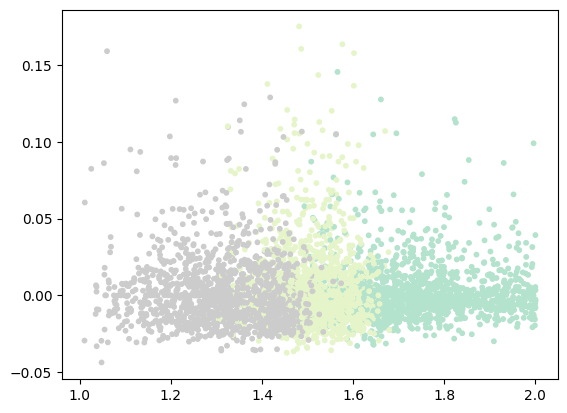

In [20]:
plt.scatter(trades["distance"],trades["return"],s=10,c=trades["group_percentile"].astype(int)*10,cmap="Pastel2")
plt.show()

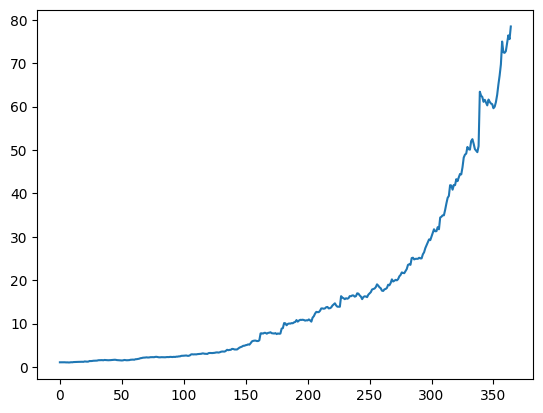

In [21]:
averaged_portfolio = portfolio.groupby("day").agg({"weighted_return":"mean","return":"mean"}).reset_index()
averaged_portfolio["pv"] = averaged_portfolio["weighted_return"].cumprod()
plt.plot(averaged_portfolio["pv"])
plt.show()

In [22]:
trades.tail(20)

,year,day,ticker,date,adjclose,sell_price,distance,ema_corr,risk,group_percentile,...,position_type,weight,unweighted_return,stoploss_return,winsorized_return,weighted_return,return,month,quarter,week
4036,2025,91,NAK,2025-04-01 00:00:00+00:00,1.11,0.9100,1.621126,0.257812,0.240522,2,...,1.0,0.464363,0.819820,0.950000,0.950000,-0.023218,-0.023218,4,2,14
4037,2025,91,HTCO,2025-04-01 00:00:00+00:00,1.11,1.1500,1.465723,0.612543,0.304545,3,...,1.0,0.366742,1.036036,1.036036,1.036036,0.013216,0.013216,4,2,14
4038,2025,92,TNON,2025-04-02 00:00:00+00:00,1.47,1.3300,1.830072,0.389189,0.469618,1,...,1.0,0.229272,0.904762,0.950000,0.950000,-0.011464,-0.011464,4,2,14
4039,2025,92,MODV,2025-04-02 00:00:00+00:00,1.43,1.2700,1.599321,0.253746,0.265369,2,...,1.0,0.405738,0.888112,0.950000,0.950000,-0.020287,-0.020287,4,2,14
4040,2025,92,MGRX,2025-04-02 00:00:00+00:00,2.14,2.0100,1.459706,0.328214,0.294996,3,...,1.0,0.364990,0.939252,0.950000,0.950000,-0.018249,-0.018249,4,2,14
4041,2025,93,OSRH,2025-04-03 00:00:00+00:00,2.47,1.9500,1.929125,0.345159,0.311993,1,...,1.0,0.308827,0.789474,0.950000,0.950000,-0.015441,-0.015441,4,2,14
4042,2025,93,RAY,2025-04-03 00:00:00+00:00,1.97,1.8500,1.584771,0.196394,0.278261,2,...,1.0,0.346265,0.939086,0.950000,0.950000,-0.017313,-0.017313,4,2,14
4043,2025,93,HTCO,2025-04-03 00:00:00+00:00,1.22,1.1350,1.471469,0.310853,0.279355,3,...,1.0,0.344908,0.930328,0.950000,0.950000,-0.017245,-0.017245,4,2,14
4044,2025,94,BDRX,2025-04-04 00:00:00+00:00,1.69,1.6500,1.706879,0.347289,0.233957,1,...,1.0,0.357803,0.976331,0.976331,0.976331,-0.008469,-0.008469,4,2,14
4045,2025,94,NWTG,2025-04-04 00:00:00+00:00,1.86,2.8200,1.554964,0.355291,0.397527,2,...,1.0,0.210578,1.516129,1.516129,1.324232,0.108686,0.068276,4,2,14
